In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append("../src")  # adjust if needed
sys.path.append("../src/simkit")

In [2]:
from simkit import (
    TradeLedger, preview_expiries, expire_trades_vectorized,
    daily_pnl_curve, realized_pnl_total,
    generate_straddle_trades
)

In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
sys.path.append("..") 
from src.load_data import  prepare_volatility_data
from src.load_data import load_pivoted_field
from src.forecast import build_forecast_pipeline
#from src.signals import generate_signals_and_positions
from src.analytic_utils import align_multiple
from src.checkpoint_storage import save_all_checkpoints_v2,load_all_checkpoints_v2
#from src.ledger_portfolio import TradeLedger, add_nyse_days










In [4]:
from src.checkpoint_storage import save_all_checkpoints_v2,load_all_checkpoints_v2
checkpoint=load_all_checkpoints_v2("../checkpoints/har_pre_model_20250804_140707")
print(type(checkpoint), checkpoint.keys() if isinstance(checkpoint, dict) else None)
ds_test=checkpoint["test"]

print(type(ds_test), ds_test.keys() if isinstance(ds_test, dict) else None)
print(checkpoint["train"]["X_df"].columns.tolist())

best_model=checkpoint["model"]
print(best_model.feature_names_in_)


idx_df=ds_test['idx']  
multi_idx = pd.MultiIndex.from_frame(idx_df, names=["timestamp", "ticker"])
multi_idx

<class 'dict'> dict_keys(['train', 'val', 'test', 'model', 'metrics', 'config', 'notes'])
<class 'dict'> dict_keys(['X_df', 'y_series', 'label_matrix', 'idx', 'features'])
['signal', 'signal_rank', 'implied', 'implied_rank']
['signal' 'signal_rank' 'implied' 'implied_rank']


MultiIndex([('2023-11-20',  'AAL'),
            ('2023-11-20',  'AAP'),
            ('2023-11-20', 'AAPL'),
            ('2023-11-20', 'ABBV'),
            ('2023-11-20',  'ABT'),
            ('2023-11-20',  'ACN'),
            ('2023-11-20', 'ADBE'),
            ('2023-11-20',  'ADM'),
            ('2023-11-20',  'ADP'),
            ('2023-11-20',  'AEP'),
            ...
            ('2023-12-29',  'WRB'),
            ('2023-12-29',  'WRK'),
            ('2023-12-29',  'WST'),
            ('2023-12-29',   'WY'),
            ('2023-12-29', 'WYNN'),
            ('2023-12-29',  'XOM'),
            ('2023-12-29',  'ZBH'),
            ('2023-12-29', 'ZBRA'),
            ('2023-12-29', 'ZION'),
            ('2023-12-29',  'ZTS')],
           names=['timestamp', 'ticker'], length=11020)

In [5]:
X_test=checkpoint["test"]["X_df"]
y_test=checkpoint["test"]["y_series"]
y_pred=best_model.predict_proba(X_test)[:,1]
y_pred_binary=np.where(y_pred>0.5,1,0)
y_test_binary=np.where(y_test>0.5,1,0)
accuracy=roc_auc_score(y_test_binary,y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7474987841253247


In [7]:
y_pred_series = pd.Series(y_pred, index=multi_idx)
y_pred_series
y_pred_matrix=y_pred_series.unstack()
y_pred_matrix
ranked = y_pred_matrix.rank(axis=1, pct=True)
ranked
buy_mask = ranked >= 0.9
sell_mask = ranked <= 0.1
buy_mask
trades = []

for dt in y_pred_matrix.index:
    for ticker in y_pred_matrix.columns:
        action = None
        if buy_mask.loc[dt, ticker]:
            action = "buy"
        elif sell_mask.loc[dt, ticker]:
            action = "sell"
        if action:
            trades.append((dt, ticker, action))

In [8]:
import json
import yaml

with open("../configs/config.json") as f:
    config_data = json.load(f)

with open("../configs/config.yaml") as f:
    config_exp = yaml.safe_load(f)

print(config_data)
print(config_exp)
vol_data = prepare_volatility_data(config_data)

{'realized_path': 'data/iv_data.parquet', 'implied_path': 'data/iv_implied.parquet', 'price_path': 'data/underlying_prices.parquet', 'forecast_horizon': 5, 'model_path': 'models/best_model.pkl', 'new_realized_path': 'data/new_realized.parquet', 'new_implied_path': 'data/new_implied.parquet', 'option_chain_path': 'data/option_chain.parquet', 'output_ledger_path': 'results/ledger.parquet', 'train_test_split_ratio': 0.7, 'train_test_gap_days': 21, 'ranking_threshold': 0.9, 'signal_z': True, 'implied_z': True, 'rf_params': {'n_estimators': 100, 'max_depth': 5}, 'har_windows': {'short': 1, 'medium': 5, 'long': 21}}
{'experiment_name': 'v2_rf_20pct', 'signal_threshold': 0.2, 'features': ['signal', 'signal_rank', 'implied', 'implied_rank'], 'model': {'type': 'random_forest', 'hyperparams': {'n_estimators': 100, 'max_depth': 5}}}


/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/load_data.py:149: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()


In [9]:
close_matrix=load_pivoted_field("close")
close_matrix.index.rename("date", inplace=True)
close_matrix.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,156.420,18.7400,236.76,182.000,135.42,132.65,139.04,44.550,407.20,564.37,...,87.75,67.95,63.545,56.900,116.90,136.56,129.13,583.89,64.270,234.01
2022-01-04,151.200,19.0200,237.16,179.690,135.14,131.40,135.76,45.130,404.48,554.10,...,87.49,68.37,65.910,57.190,118.10,137.31,130.44,587.06,66.055,225.04
2022-01-05,148.680,18.6900,236.45,174.835,135.88,132.50,135.17,44.595,397.25,514.28,...,84.25,69.05,66.740,56.270,116.57,135.58,130.01,558.65,66.200,216.65
2022-01-06,149.110,18.5653,241.59,172.010,135.20,130.45,135.14,44.855,378.01,514.05,...,84.64,68.52,68.310,56.210,116.36,136.90,128.92,555.16,68.930,217.46
2022-01-07,145.142,19.2900,238.09,172.220,134.88,133.12,135.54,45.080,370.75,510.63,...,84.53,69.12,68.880,56.405,115.39,135.37,128.14,530.57,70.080,211.09


In [10]:
def get_daily_snapshot(
    date: pd.Timestamp,
    close_matrix: pd.DataFrame,
    iv_matrix: pd.DataFrame
) -> pd.DataFrame:
    """
    Return a DataFrame with 'ticker', 'close', 'implied_vol' for a given date.
    """
    close_row = close_matrix.loc[date]
    iv_row = iv_matrix.loc[date]

    common_tickers = close_row.index.intersection(iv_row.index)

    df = pd.DataFrame({
        "ticker": common_tickers,
        "close": close_row[common_tickers].values,
        "implied_vol": iv_row[common_tickers].values
    }).dropna()

    return df

df=get_daily_snapshot(pd.Timestamp("2022-07-28"), close_matrix, vol_data["implied"])

In [11]:
ledger=TradeLedger()
generate_straddle_trades(trades, close_matrix, vol_data["implied"],ledger)

/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/simkit/ledger.py:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trades_df = pd.concat([self.trades_df, normalized], ignore_index=True)


In [13]:
ledger.trades

,timestamp,action,instrument_type,underlying,option_type,strike,expiry,quantity,price,signed_quantity,total_cost,trade_id
0,2023-11-20 05:00:00+00:00,sell,option,AAL,call,12.390,2023-11-28,0.080710,0.222394,-0.080710,-0.017949,4b15b71f2a714ca84514d4c5
1,2023-11-20 05:00:00+00:00,sell,option,CZR,put,46.260,2023-11-28,0.021617,0.933517,-0.021617,-0.020180,d2968ad549d021cc916b0d0d
2,2023-11-20 05:00:00+00:00,buy,option,DD,put,71.380,2023-11-28,0.014010,0.586937,0.014010,0.008223,fe8cb46aff0e9a941cc4669c
3,2023-11-20 05:00:00+00:00,sell,option,DISH,put,3.655,2023-11-28,0.273598,0.167796,-0.273598,-0.045908,89cf914c9441b83748a08f24
4,2023-11-20 05:00:00+00:00,sell,option,DXCM,put,109.010,2023-11-28,0.009173,2.194505,-0.009173,-0.020131,991e63d437715625de9a81a2
...,...,...,...,...,...,...,...,...,...,...,...,...
4415,2023-12-29 05:00:00+00:00,buy,option,NDSN,call,264.190,2024-01-08,0.003785,2.321308,0.003785,0.008787,418391750d9985bcd7e6027e
4416,2023-12-29 05:00:00+00:00,buy,option,NTAP,call,88.150,2024-01-08,0.011344,0.784142,0.011344,0.008896,53834a25bc2052e0d4bf7c50
4417,2023-12-29 05:00:00+00:00,sell,option,NTRS,call,84.380,2024-01-08,0.011851,1.527488,-0.011851,-0.018102,d256e3cac7c46da5ac08254d
4418,2023-12-29 05:00:00+00:00,buy,option,HON,call,209.730,2024-01-08,0.004768,1.567545,0.004768,0.007474,9b629c5e0ffe5f24c045aa59


In [14]:
from src.ledger_portfolio import (
    TradeLedger, PortfolioView, expire_trades_vectorized,
    to_nyc, ny_date, session_close_utc, Action, OptionType
)

ledger.trades

,timestamp,action,instrument_type,underlying,option_type,strike,expiry,quantity,price,signed_quantity,total_cost,trade_id
0,2023-11-20 05:00:00+00:00,sell,option,AAL,call,12.390,2023-11-28,0.080710,0.222394,-0.080710,-0.017949,4b15b71f2a714ca84514d4c5
1,2023-11-20 05:00:00+00:00,sell,option,CZR,put,46.260,2023-11-28,0.021617,0.933517,-0.021617,-0.020180,d2968ad549d021cc916b0d0d
2,2023-11-20 05:00:00+00:00,buy,option,DD,put,71.380,2023-11-28,0.014010,0.586937,0.014010,0.008223,fe8cb46aff0e9a941cc4669c
3,2023-11-20 05:00:00+00:00,sell,option,DISH,put,3.655,2023-11-28,0.273598,0.167796,-0.273598,-0.045908,89cf914c9441b83748a08f24
4,2023-11-20 05:00:00+00:00,sell,option,DXCM,put,109.010,2023-11-28,0.009173,2.194505,-0.009173,-0.020131,991e63d437715625de9a81a2
...,...,...,...,...,...,...,...,...,...,...,...,...
4415,2023-12-29 05:00:00+00:00,buy,option,NDSN,call,264.190,2024-01-08,0.003785,2.321308,0.003785,0.008787,418391750d9985bcd7e6027e
4416,2023-12-29 05:00:00+00:00,buy,option,NTAP,call,88.150,2024-01-08,0.011344,0.784142,0.011344,0.008896,53834a25bc2052e0d4bf7c50
4417,2023-12-29 05:00:00+00:00,sell,option,NTRS,call,84.380,2024-01-08,0.011851,1.527488,-0.011851,-0.018102,d256e3cac7c46da5ac08254d
4418,2023-12-29 05:00:00+00:00,buy,option,HON,call,209.730,2024-01-08,0.004768,1.567545,0.004768,0.007474,9b629c5e0ffe5f24c045aa59


In [44]:
NY="America/New_York"
def _assert_add_nyse_days():
    # 1) Naive datetime on a weekday
    a = add_nyse_days([pd.Timestamp("2025-08-07 10:00")], 5)
    assert isinstance(a[0], pd.Timestamp("2025-08-14").date().__class__)

    # 2) tz-aware NY on a weekend -> roll forward to Monday
    b = add_nyse_days([pd.Timestamp("2025-08-09", tz=NY)], 1)  # 2025-08-09 is Sat
    # Should land on Tuesday if Monday is 0 days forward, or Wednesday if a holiday—assert monotonicity:
    assert b[0] >= pd.Timestamp("2025-08-11").date()

    # 3) Batch inputs mixed (naive + tz-aware)
    c = add_nyse_days([pd.Timestamp("2025-11-27"),  # Thanksgiving (US holiday)
                       pd.Timestamp("2025-11-28", tz=NY)], 1)
    # Both should return the same next valid day after their respective rolled start
    assert len(c) == 2

_assert_add_nyse_days()
print("add_nyse_days basic tests passed.")

add_nyse_days basic tests passed.


In [15]:
from datetime import date
# close_matrix: index = dates (date or tz-naive midnight), columns = symbols
# Example columns: ["SPX", "QQQ", "AAPL", ...]
def px_lookup(symbols: np.ndarray, d: date) -> np.ndarray:
    # normalize the index to plain dates for robust matching
    idx = pd.Index(close_matrix.index)
    if isinstance(idx.dtype, pd.DatetimeTZDtype) or np.issubdtype(idx.dtype, np.datetime64):
        idx_dates = pd.to_datetime(idx).tz_localize(None).date
    else:
        idx_dates = pd.to_datetime(idx).date
    # map date -> row position once
    date_pos = {dt: i for i, dt in enumerate(idx_dates)}
    if d not in date_pos:
        raise KeyError(f"No close price row for {d} in close_matrix.")
    row = close_matrix.iloc[date_pos[d]]

    # gather prices in the same order as symbols
    out = []
    missing = []
    for s in symbols:
        if s in row.index and pd.notna(row[s]):
            out.append(float(row[s]))
        else:
            missing.append(s)
            out.append(np.nan)
    if missing:
        raise KeyError(f"Missing prices on {d} for: {sorted(set(missing))}")
    return np.array(out, dtype=float)

In [16]:
# choose the backtest window
# --- derive start/end from your ledger + data ---
from src.simkit.time_utils import to_nyc
from src.simkit.calendar_utils import nyse_days
import pandas as pd


ts_ny   = to_nyc(ledger.trades["timestamp"])           # tz-aware NY
start_day = ts_ny.dt.date.min()
end_day   = max(ledger.trades["expiry"].max(),
                pd.to_datetime(close_matrix.index).tz_localize(None).date.max())

# --- NYSE calendar (prefer pandas_market_calendars if available) --

# --- union with price matrix dates ---
price_days = pd.to_datetime(close_matrix.index).tz_localize(None).date
cal_days   = nyse_days(start_day, end_day)

sim_days = sorted(set(cal_days) & set(price_days))

# --- run expiry over union days ---
audit = []
for d in sim_days:
    audit.append(expire_trades_vectorized(ledger, d, px_lookup,return_audit=True))

In [17]:
audit[12]

,close_timestamp_utc,underlying,option_type,strike,expiry,action,qty_to_close,spot,payoff
0,2023-12-07 21:30:00+00:00,AAL,call,12.4500,2023-12-07,buy,0.080321,13.92,1.4700
1,2023-12-07 21:30:00+00:00,AAL,put,12.4500,2023-12-07,buy,0.080321,13.92,0.0000
2,2023-12-07 21:30:00+00:00,AAP,call,50.7900,2023-12-07,buy,0.019689,56.19,5.4000
3,2023-12-07 21:30:00+00:00,AAP,put,50.7900,2023-12-07,buy,0.019689,56.19,0.0000
4,2023-12-07 21:30:00+00:00,AEP,call,79.5500,2023-12-07,sell,0.012571,80.17,0.6200
...,...,...,...,...,...,...,...,...,...
143,2023-12-07 21:30:00+00:00,WDC,put,48.3300,2023-12-07,buy,0.020691,47.31,1.0200
144,2023-12-07 21:30:00+00:00,WYNN,call,84.4275,2023-12-07,buy,0.011844,82.54,0.0000
145,2023-12-07 21:30:00+00:00,WYNN,put,84.4275,2023-12-07,buy,0.011844,82.54,1.8875
146,2023-12-07 21:30:00+00:00,ZION,call,35.6350,2023-12-07,buy,0.028062,38.37,2.7350


In [36]:
def realized_pnl_total(ledger) -> float:
    df = ledger.trades
    return (-df["total_cost"]).sum()

def daily_pnl_curve(ledger) -> pd.DataFrame:
    df = ledger.trades.copy()
    df["day_ny"] = to_nyc(df["timestamp"]).dt.date  # bucket by NY day
    df["cash_flow"] = -df["total_cost"]
    out = df.groupby("day_ny")["cash_flow"].sum().to_frame("daily_pnl")
    out["cum_pnl"] = out["daily_pnl"].cumsum()
    return out.reset_index()

<Axes: >

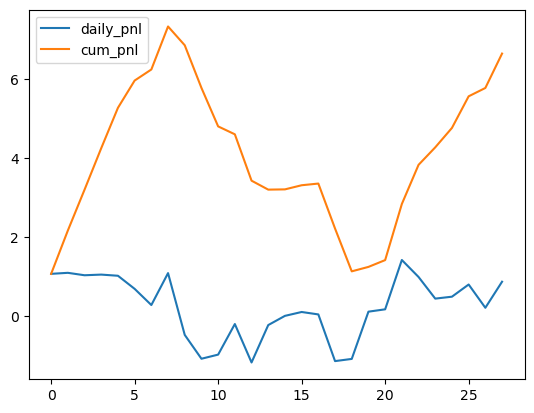

In [18]:
pnl_plot=daily_pnl_curve(ledger)
pnl_plot.plot()

In [20]:
from datetime import date, time
from typing import Callable
import numpy as np
import pandas as pd
from src.ledger_portfolio import TradeLedger, PortfolioView


def preview_expiries(
    ledger: TradeLedger,
    as_of_date: date,
    price_lookup_fn: Callable[[np.ndarray, date], np.ndarray],
    close_time: time = time(16,30),
) -> pd.DataFrame:
    """
    Compute what WOULD be expired on as_of_date at NY close, with full details.
    Does NOT write to the ledger. Returns a DataFrame you can inspect/assert.
    """
    close_ts_utc = session_close_utc(as_of_date, close=close_time)
    opens = PortfolioView(ledger).positions_at(close_ts_utc)
    if opens.empty:
        return pd.DataFrame(columns=[
            "close_timestamp_utc","underlying","option_type","strike","expiry",
            "open_signed_qty","action","qty_to_close","spot","payoff"
        ])

    to_close = opens[opens["expiry"] <= as_of_date].copy()
    if to_close.empty:
        return pd.DataFrame(columns=[
            "close_timestamp_utc","underlying","option_type","strike","expiry",
            "open_signed_qty","action","qty_to_close","spot","payoff"
        ])

    symbols = to_close["underlying"].to_numpy()
    spots   = price_lookup_fn(symbols, as_of_date)

    payoffs = compute_payoff_vec(
        np.asarray(spots, dtype=float),
        to_close["strike"].to_numpy(dtype=float),
        to_close["option_type"].to_numpy(dtype=str)
    )
    actions = np.where(to_close["signed_quantity"].to_numpy(dtype=float) > 0, "sell", "buy")
    qtys    = np.abs(to_close["signed_quantity"].to_numpy(dtype=float))

    out = pd.DataFrame({
        "close_timestamp_utc": close_ts_utc,
        "underlying":          to_close["underlying"].to_numpy(),
        "option_type":         to_close["option_type"].to_numpy(),
        "strike":              to_close["strike"].to_numpy(dtype=float),
        "expiry":              to_close["expiry"].to_numpy(object),   # date
        "open_signed_qty":     to_close["signed_quantity"].to_numpy(dtype=float),
        "action":              actions,
        "qty_to_close":        qtys,
        "spot":                np.asarray(spots, dtype=float),
        "payoff":              payoffs,
    })
    # Convenience: what ledger would record as price/total_cost for the close
    out["expected_close_price"] = out["payoff"]
    out["expected_signed_qty"]  = np.where(out["action"]=="buy", out["qty_to_close"], -out["qty_to_close"])
    out["expected_total_cost"]  = out["expected_signed_qty"] * out["expected_close_price"]
    return out

In [21]:
def reconcile_expiries(ledger: TradeLedger, audit_df: pd.DataFrame) -> pd.DataFrame:
    """
    Join expected vs. actual closing trades at the same close timestamp & instrument key.
    Returns rows where price/qty/action mismatch.
    """
    if audit_df.empty:
        return audit_df

    # Extract the closes we just booked at that timestamp
    key_cols = ["underlying","option_type","strike","expiry","action"]
    closes = ledger.trades_df.copy()
    closes = closes[closes["timestamp"] == pd.to_datetime(audit_df["close_timestamp_utc"].iloc[0])]
    closes = closes[closes["instrument_type"] == "option"]

    left = audit_df.rename(columns={
        "qty_to_close":"qty_expected",
        "payoff":"price_expected"
    })[["close_timestamp_utc"] + key_cols + ["qty_expected","price_expected"]]

    right = closes.rename(columns={
        "quantity":"qty_actual",
        "price":"price_actual"
    })[["timestamp"] + key_cols + ["qty_actual","price_actual"]]

    merged = left.merge(
        right,
        left_on=["close_timestamp_utc"]+key_cols,
        right_on=["timestamp"]+key_cols,
        how="left"
    )

    mism = merged[
        (merged["qty_expected"]  != merged["qty_actual"]) |
        (merged["price_expected"]!= merged["price_actual"])
    ].copy()

    return mism.drop(columns=["timestamp"])

In [22]:
PortfolioView(ledger).positions_at(pd.Timestamp("2023-12-31",tz="America/New_York"))

,instrument_type,underlying,option_type,strike,expiry,signed_quantity
12,option,AAL,call,13.740,2024-01-08,-0.072780
14,option,AAL,call,13.970,2024-01-05,-0.071582
15,option,AAL,call,14.000,2024-01-04,-0.071429
16,option,AAL,call,14.115,2024-01-03,-0.070847
19,option,AAL,call,14.320,2024-01-02,-0.069832
...,...,...,...,...,...,...
4413,option,ZION,put,43.870,2024-01-08,-0.022795
4415,option,ZION,put,44.025,2024-01-02,-0.022714
4416,option,ZION,put,44.540,2024-01-04,-0.022452
4417,option,ZION,put,44.670,2024-01-05,-0.022386


In [23]:
audit[8]

,close_timestamp_utc,underlying,option_type,strike,expiry,action,qty_to_close,spot,payoff
0,2023-12-01 21:30:00+00:00,AAL,call,12.31,2023-12-01,buy,0.081235,13.035,0.725
1,2023-12-01 21:30:00+00:00,AAL,put,12.31,2023-12-01,buy,0.081235,13.035,0.000
2,2023-12-01 21:30:00+00:00,AAP,call,53.08,2023-12-01,buy,0.018839,54.070,0.990
3,2023-12-01 21:30:00+00:00,AAP,put,53.08,2023-12-01,buy,0.018839,54.070,0.000
4,2023-12-01 21:30:00+00:00,ABT,call,102.87,2023-12-01,sell,0.009721,104.890,2.020
...,...,...,...,...,...,...,...,...,...
155,2023-12-01 21:30:00+00:00,WBA,put,20.85,2023-12-01,buy,0.047962,20.800,0.050
156,2023-12-01 21:30:00+00:00,WBD,call,10.85,2023-12-01,buy,0.092166,11.335,0.485
157,2023-12-01 21:30:00+00:00,WBD,put,10.85,2023-12-01,buy,0.092166,11.335,0.000
158,2023-12-01 21:30:00+00:00,ZION,call,34.35,2023-12-01,buy,0.029112,38.320,3.970


In [24]:
# microtests cell – no top-level exports required
import sys; sys.path.append("../src")
from simkit.ledger import TradeLedger
from simkit.expiry import preview_expiries, expire_trades_vectorized
from simkit.pnl import daily_pnl_curve, realized_pnl_total
from simkit.strategies import generate_straddle_trades
from simkit.time_utils import to_nyc, to_utc, session_close_utc
from simkit.datetime_utils import to_date_only

import numpy as np, pandas as pd
from datetime import date
from simkit.strategies import generate_straddle_trades

# --- tiny fixtures -----------------------------------------------------------
def _toy_data():
    # trading days (mon–fri), simple SPX path
    days = pd.date_range("2025-08-04", "2025-08-20", freq="B")
    close = pd.DataFrame({"SPX": np.linspace(5500, 5560, len(days))}, index=days)
    vol   = pd.DataFrame({"SPX": 0.20}, index=days)
    return close, vol, days

def _px_lookup_factory(close_matrix):
    # price lookup matching your expire_trades_vectorized signature
    def px_lookup(symbols, d):
        # normalize to date and hit index exactly
        idx = pd.to_datetime(close_matrix.index).tz_localize(None).normalize()
        pos = {dt.date(): i for i, dt in enumerate(idx)}
        row = close_matrix.iloc[pos[date.fromisoformat(str(d))]]
        return np.array([float(row[s]) for s in symbols], dtype=float)
    return px_lookup

# --- tests -------------------------------------------------------------------
def test_utils_roundtrip():
    t = pd.Timestamp("2025-03-10 12:34", tz="America/New_York")
    u = to_utc(t)
    ny = to_nyc(u)
    assert to_date_only(ny) == date(2025, 3, 10)

def test_generate_and_expire_straddle_ITM():
    close, vol, days = _toy_data()
    px_lookup = _px_lookup_factory(close)

    # trade on first day; 2-day TTM so we’ll expire on the 3rd trading day
    trade_ts = days[0].tz_localize("America/New_York").replace(hour=10, minute=0)
    trades = [(trade_ts, "SPX", "buy")]  # one straddle buy

    ledger = TradeLedger()
    # build both call+put at ATM
    batch = generate_straddle_trades(
        trades=trades,
        close_matrix=close,
        vol_matrix=vol,
        ledger=ledger,
        ttm_days=2,
        r=0.0, q=0.0,
        return_df=True
    )
    # expect 2 rows (call+put)
    assert len(batch) == 2
    assert set(batch["option_type"]) == {"call", "put"}
    assert batch["expiry"].nunique() == 1

    # preview expiry (no write)
    exp_day = to_date_only(batch["expiry"].iloc[0])
    audit = preview_expiries(ledger, exp_day, px_lookup)
    assert not audit.empty
    assert set(audit["option_type"]) == {"call", "put"}

    # execute expiry (write close trades)
    expire_trades_vectorized(ledger, exp_day, px_lookup)

    # sanity: realized PnL is payoff minus cost; since we bought both legs,
    # net result depends on spot move. We only assert consistency (no NaNs).
    df = ledger.trades
    assert df["price"].notna().all()
    assert df["quantity"].notna().all()

def test_pnl_consistency():
    # total realized equals sum of cash flows
    ledger = TradeLedger()
    # two artificial cashflows: buy 1 @ 10, sell 1 @ 15
    t0 = pd.Timestamp("2025-01-02 10:00", tz="America/New_York")
    t1 = pd.Timestamp("2025-01-03 16:30", tz="America/New_York")
    ledger.record_trades(pd.DataFrame([
        {"timestamp": t0, "action":"buy","instrument_type":"option","underlying":"SPX",
         "option_type":"call","strike":5500,"expiry":date(2025,1,17),"quantity":1,"price":10,
         "signed_quantity": 1, "total_cost": 10},
        {"timestamp": t1, "action":"sell","instrument_type":"option","underlying":"SPX",
         "option_type":"call","strike":5500,"expiry":date(2025,1,17),"quantity":1,"price":15,
         "signed_quantity":-1, "total_cost":-15},
    ]))
    total = realized_pnl_total(ledger)
    cash = (-ledger.trades["total_cost"]).sum()
    assert abs(total - cash) < 1e-9
    curve = daily_pnl_curve(ledger)
    assert {"day_ny","daily_pnl","cum_pnl"}.issubset(curve.columns)

def run_all_microtests():
    tests = [
        test_utils_roundtrip,
        test_generate_and_expire_straddle_ITM,
        test_pnl_consistency,
    ]
    for t in tests:
        t()
    print("✅ microtests passed")

run_all_microtests()

✅ microtests passed


/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/simkit/ledger.py:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trades_df = pd.concat([self.trades_df, normalized], ignore_index=True)
/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/simkit/ledger.py:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trades_df = pd.concat([self.trades_df, normalized], ignore_index=True)
